# Peaks Heatmap

Creates a peak count heatmap per cluster.

Inputs:
1. `metadata.tsv` with UMAP/densMAP coordinates, day and cluster.
2. Config:
    - Colours for each day
    - For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)
3. Single-cell counts matrix derived from snapATAC with corresponding peaks.
4. Set of bed files corresponding to peak sets which are a subset of peaks in the above matrix.

In [77]:
library(Matrix)
library(ggplot2)
library(patchwork)
library(GenomicRanges)
library(scales)
library(DESeq2)
library(reshape2)
library(viridis)

Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

### MetaData

In [15]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 68916     5

,barcode,sample,umap1,umap2,cells
,<fct>,<fct>,<dbl>,<dbl>,<chr>
D0_AAACAACGACGATTAC,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA


In [16]:
# this is a kludge for now, clusters should also be present in same metaData as above
snapATAC_metaData = read.table("../../analysis/20200122_snapATAC/snapATAC_sessions/20200518_n76052/metadata.tsv", header = T)
rownames(snapATAC_metaData) = paste(snapATAC_metaData$sample, snapATAC_metaData$barcode, sep='_')

metaData$cluster = snapATAC_metaData[rownames(metaData), "cluster"] 
head(metaData)

,barcode,sample,umap1,umap2,cells,cluster
,<fct>,<fct>,<dbl>,<dbl>,<chr>,<int>
D0_AAACAACGACGATTAC,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC,5
D0_AAACAACGAGCGCACT,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT,5
D0_AAACACGCTACGCCAC,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC,5
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG,6
D0_AAACACGCTCCTCAAA,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA,5
D0_AAACACGCTCGAGTGA,AAACACGCTCGAGTGA,D0,3.408866,-9.058377,D0_AAACACGCTCGAGTGA,6


### Day and Cluster Configs

In [6]:
day_config = read.table("../configs/day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=DAYS)
rownames(day_config) = day_config$day
day_config

,day,colour
,<fct>,<chr>
D0,D0,#336699
D2,D2,#0AABB7
D4,D4,#D6E82F
D6,D6,#B14AED
D8,D8,#2D3142
D10,D10,#FC7753
D12,D12,#FF70A6
D14,D14,#A61C24


In [98]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

rownames(cluster_config) = cluster_config$cluster
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#CCCCCC,Intermediate,12
2,2,#E41A1C,Pre-iPSC,15
3,3,#377EB8,Fibroblast-like,5
4,4,#4DAF4A,Fibroblast-like,3
5,5,#984EA3,Fibroblast,1
6,6,#FF7F00,Fibroblast,2
7,7,#4B644A,Fibroblast-like,4
8,8,#A65628,Doublets,17
9,9,#F781BF,Keratinocyte-like,6


### Insertions Count Matrix + Regions

In [8]:
pmat = readMM("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/pmat.overlap.smallpeaks.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  68916 803958

In [9]:
peak_regions = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.overlap.smallpeaks.bed")
names(peak_regions) = c("chr", "bp1", "bp2")
peak_regions$site_name <- paste(peak_regions$chr, peak_regions$bp1, peak_regions$bp2, sep="_")
row.names(peak_regions) <- peak_regions$site_name
dim(peak_regions)
head(peak_regions)

[1] 803958      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_97145604_97145864,chr1,97145604,97145864,chr1_97145604_97145864
chr1_7538148_7538363,chr1,7538148,7538363,chr1_7538148_7538363
chr1_93196678_93196894,chr1,93196678,93196894,chr1_93196678_93196894
chr1_187577713_187577913,chr1,187577713,187577913,chr1_187577713_187577913
chr1_53278065_53278265,chr1,53278065,53278265,chr1_53278065_53278265
chr1_177176832_177177032,chr1,177176832,177177032,chr1_177176832_177177032


In [10]:
peak_regions_gr =  GRanges(sub("_", "-", sub("_", ":", rownames(peak_regions))))

In [11]:
# check if reads at OCT promoter (none in initial version)
sum(pmat[,subjectHits(findOverlaps(GRanges(c("chr6:31170549-31170836")), peak_regions_gr))])

[1] 537

In [12]:
pmatRowSums = Matrix::rowSums(pmat)

### Cluster Aggregated Matrix

In [99]:
# CAREFUL: reassigning clusters to their new cluster labels! 
# ensure cluster_config is in order
new_cluster_per_cell = cluster_config$new_cluster[metaData$cluster]

agg_matrix = sparseMatrix(i=new_cluster_per_cell,
                         j=seq(1,nrow(pmat)),
                         x=1L,
                         dims=c(length(table(new_cluster_per_cell)), nrow(pmat)))

In [396]:
cts = as.matrix(agg_matrix %*% pmat)
colnames(cts) = sub("_", "-", sub("_", ":", rownames(peak_regions)))
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)
dim(cts)

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18
chr1:97145604-97145864,103,145,74,141,34,43,24,30,14,73,79,74,20,33,8,8,38,0
chr1:7538148-7538363,193,233,151,314,19,78,29,34,14,96,55,62,73,12,39,8,40,0
chr1:93196678-93196894,82,67,12,23,2,5,1,18,1,12,1,10,4,0,3,1,6,0
chr1:187577713-187577913,47,31,27,7,0,1,1,5,11,29,10,22,14,0,4,0,6,0
chr1:53278065-53278265,51,26,40,58,3,24,16,12,12,37,25,47,35,5,11,5,12,0
chr1:177176832-177177032,10,4,3,11,3,0,12,59,118,45,6,73,21,0,4,2,5,0


[1] 803958     18

In [397]:
# removing cluster_18 (iPSC) for now since it has very few cells
cts = cts[,1:17]

In [398]:
sum(rowSums(cts<10)==0)

[1] 157610

In [399]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts[rowSums(cts<10)==0, ]))

In [400]:
# bin length normalized
binnorm_log_cts = log2(1+200*(norm_cts/width(GRanges(rownames(norm_cts)))))

In [401]:
head(binnorm_log_cts)

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
chr1:97145604-97145864,5.246563,6.103949,5.142254,5.762659,6.605542,5.175388,4.979347,4.772335,4.099198,5.031476,6.0159274,4.647093,3.466929,5.804131,2.796274,3.973818,5.061117
chr1:7538148-7538363,6.404163,7.051036,6.419734,7.173951,6.046133,6.285670,5.510901,5.211614,4.357630,5.683187,5.7707261,4.664150,5.503252,4.650290,5.171057,4.230918,5.398868
chr1:93196678-93196894,5.185653,5.273154,2.943568,3.517980,2.966969,2.564153,1.339581,4.321943,1.254907,2.861700,0.9781839,2.295719,1.773708,0.000000,1.880515,1.683437,2.837983
chr1:187577713-187577913,4.517405,4.308664,4.109216,2.149078,0.000000,1.043379,1.407424,2.743722,4.126457,4.117305,3.5200407,3.362709,3.342221,0.000000,2.281179,0.000000,2.933528
chr1:53278065-53278265,4.630292,4.068840,4.648829,4.880935,3.590072,4.726024,4.778318,3.875300,4.245088,4.450691,4.7644690,4.381268,4.576167,3.560263,3.538173,3.693763,3.835877
chr1:177176832-177177032,2.500805,1.777365,1.488759,2.677745,3.590072,0.000000,4.380699,6.092460,7.472753,4.721314,2.8645684,4.991634,3.878968,0.000000,2.281179,2.530069,2.707776


### Peak Sets

In [13]:
BASE_PATH = "../../analysis/20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40/"
list.files(BASE_PATH)

[1] "all_peaks.bed" "idx1.bed"      "idx10.bed"     "idx11.bed"    
 [5] "idx12.bed"     "idx13.bed"     "idx14.bed"     "idx15.bed"    
 [9] "idx16.bed"     "idx17.bed"     "idx18.bed"     "idx19.bed"    
[13] "idx2.bed"      "idx20.bed"     "idx21.bed"     "idx22.bed"    
[17] "idx23.bed"     "idx24.bed"     "idx25.bed"     "idx26.bed"    
[21] "idx27.bed"     "idx28.bed"     "idx29.bed"     "idx3.bed"     
[25] "idx30.bed"     "idx31.bed"     "idx32.bed"     "idx33.bed"    
[29] "idx34.bed"     "idx35.bed"     "idx36.bed"     "idx37.bed"    
[33] "idx38.bed"     "idx39.bed"     "idx4.bed"      "idx40.bed"    
[37] "idx5.bed"      "idx6.bed"      "idx7.bed"      "idx8.bed"     
[41] "idx9.bed"

In [14]:
PEAK_SET_BEDS = list.files(BASE_PATH, 
                           full.names=T,
                          pattern="*idx*")
PEAK_SET_NAMES = sub(".bed", "", list.files(BASE_PATH, 
                          pattern="*idx*"))
length(PEAK_SET_BEDS)
length(PEAK_SET_NAMES)

[1] 40

[1] 40

In [791]:
PEAK_SET_BEDS
PEAK_SET_NAMES

[1] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx1.bed" 
 [2] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx2.bed" 
 [3] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx3.bed" 
 [4] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx4.bed" 
 [5] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx5.bed" 
 [6] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx6.bed" 
 [7] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx7.bed" 
 [8] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx8.bed" 
 [9] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx9.bed" 
[10] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx10.bed"
[11] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx11.bed"
[12] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx12.bed"
[13] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx13.bed"
[14] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx14.bed"
[15] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx15.bed"
[16] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx16.bed"
[17] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx17.bed"
[18] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx18.bed"
[19] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx19.bed"
[20] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx20.bed"
[21] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx21.bed"
[22] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx22.bed"
[23] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx23.bed"
[24] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx24.bed"
[25] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx25.bed"
[26] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx26.bed"
[27] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx27.bed"
[28] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx28.bed"
[29] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx29.bed"
[30] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx30.bed"
[31] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx31.bed"
[32] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx32.bed"
[33] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx33.bed"
[34] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx34.bed"
[35] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx35.bed"
[36] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx36.bed"
[37] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx37.bed"
[38] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx38.bed"
[39] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx39.bed"
[40] "../20200307_fine_clustering/beds/20200602_gridmap_peakwidthnorm_logplusznorm_n40//idx40.bed"

[1] "idx1"  "idx2"  "idx3"  "idx4"  "idx5"  "idx6"  "idx7"  "idx8"  "idx9" 
[10] "idx10" "idx11" "idx12" "idx13" "idx14" "idx15" "idx16" "idx17" "idx18"
[19] "idx19" "idx20" "idx21" "idx22" "idx23" "idx24" "idx25" "idx26" "idx27"
[28] "idx28" "idx29" "idx30" "idx31" "idx32" "idx33" "idx34" "idx35" "idx36"
[37] "idx37" "idx38" "idx39" "idx40"

Assign peak set indices to peaks and remove peaks that aren't in any peak set.

In [408]:
peak_to_row_idx = rep(-1, nrow(binnorm_log_cts))

# assign peak set indices to peaks
for (i in seq(length(PEAK_SET_NAMES))) {
    cur_peaks = read.table(PEAK_SET_BEDS[[i]])
    peak_to_row_idx[rownames(binnorm_log_cts) %in% paste(paste(cur_peaks$V1, cur_peaks$V2, sep=':'), cur_peaks$V3, sep='-')] = PEAK_SET_NAMES[[i]]
}

In [409]:
sum(peak_to_row_idx== -1)

[1] 40791

In [410]:
binnorm_log_cts = binnorm_log_cts[peak_to_row_idx != -1, ]
dim(binnorm_log_cts)

[1] 763167     17

In [411]:
peak_to_row_idx = peak_to_row_idx[peak_to_row_idx != -1]

In [412]:
head(peak_to_row_idx)

[1] "idx4"  "idx2"  "idx25" "idx25" "idx36" "idx6"

## Plotting

In [413]:
## use this to filter by peak sets if required
PEAK_SETS_TO_EXCLUDE = c("idx2", "idx5", "idx9", "idx12", "idx15", "idx20", "idx22", "idx23", "idx26", "idx40", "idx34", "idx16", "idx17")
include_peak_set = !(peak_to_row_idx %in% PEAK_SETS_TO_EXCLUDE)

matrix_to_plot = binnorm_log_cts[include_peak_set, 1:16]
assigned_peak_idx = peak_to_row_idx[include_peak_set]

In [414]:
dim(matrix_to_plot)
length(assigned_peak_idx)

[1] 532161     16

[1] 532161

In [415]:
# compute median for each peak set to figure out order
median_matrix = aggregate(matrix_to_plot, list(assigned_peak_idx), median)
rownames(median_matrix) = median_matrix$Group.1
median_matrix$Group.1 = NULL
dim(median_matrix)
head(median_matrix)

[1] 27 16

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
idx1,2.404095,2.312578,2.926349,3.063789,3.063799,3.399095,4.133708,5.769794,5.520630,4.163441,3.520041,4.546741,4.114731,3.259619,3.759948,3.399442
idx10,3.921628,3.851193,4.783794,4.729032,5.374672,4.143679,3.664273,4.083579,3.855191,4.455209,4.523005,4.197428,4.234955,4.750131,3.826259,3.475904
idx11,2.867282,2.837464,3.741840,4.367508,3.829002,4.542042,6.293049,6.617730,7.329477,6.206990,6.021153,6.796677,5.796877,4.695956,4.495430,3.411195
idx13,4.106792,4.080139,4.149764,4.259932,3.590072,4.055509,4.380699,5.315545,4.781818,4.244015,3.869235,3.971314,3.671965,2.902610,2.615375,2.361156
idx14,3.195910,3.078340,3.538166,3.725238,3.968141,3.663520,3.448343,3.719824,3.855191,3.886251,3.878343,4.259517,4.571290,4.457760,5.287544,5.480110
idx18,1.924483,1.777365,2.296373,2.300481,2.226773,2.656553,3.591466,6.092460,4.551719,2.967638,2.375397,2.858352,2.637796,2.399438,2.281179,1.760432


In [454]:
# order peak sets -- using a heurestic here to get diagonal structure
# peak_set_order = rownames(median_matrix)[order(rowSums(t(seq(1,ncol(median_matrix))*t(2**(median_matrix)-1)))/rowSums(2**(median_matrix)-1))]
peak_set_order = rownames(median_matrix)[order(rowSums(t(seq(1,ncol(median_matrix))*t(median_matrix)))/rowSums(median_matrix))]
# peak_set_order = rownames(median_matrix)[order(rowSums(t(seq(1,ncol(median_matrix))*(scale(t(median_matrix))))))]
peak_set_order

[1] "idx32" "idx37" "idx25" "idx3"  "idx29" "idx4"  "idx24" "idx13" "idx39"
[10] "idx10" "idx28" "idx36" "idx33" "idx18" "idx6"  "idx1"  "idx11" "idx8" 
[19] "idx27" "idx14" "idx21" "idx38" "idx30" "idx31" "idx19" "idx7"  "idx35"

In [455]:
melted_median_matrix = melt(as.matrix(median_matrix))
melted_median_matrix$Var1 = factor(melted_median_matrix$Var1, levels = rev(peak_set_order))
melted_median_matrix$Var2 = factor(melted_median_matrix$Var2, levels = colnames(median_matrix))
head(melted_median_matrix, 2)

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,idx1,cluster_1,2.404095
2,idx10,cluster_1,3.921628


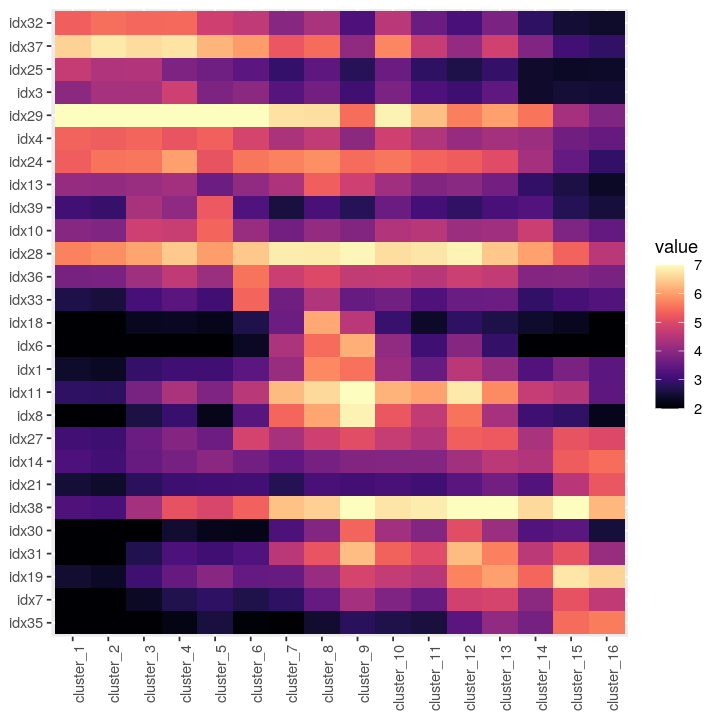

In [456]:
options(repr.plot.width = 6, repr.plot.height = 6)

# trial with peak set median accessibility
ggplot(data = melted_median_matrix, 
       aes(x = Var2, y = Var1, fill = value)) +
geom_tile()  + ylab(NULL) + xlab(NULL) +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(2, 7), oob=squish, option = "A") +
theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [458]:
dim(matrix_to_plot)

[1] 532161     16

In [459]:
SUBSAMPLE = 50

In [460]:
matrix_to_plot_ordered = matrix_to_plot[order(factor(assigned_peak_idx,
                                                    levels=rev(peak_set_order))), ]

matrix_to_plot_ordered = matrix_to_plot_ordered[seq(1, nrow(matrix_to_plot_ordered), SUBSAMPLE), ]
dim(matrix_to_plot_ordered)

[1] 10644    16

In [461]:
melted_matrix_to_plot = melt(as.matrix(matrix_to_plot_ordered))
melted_matrix_to_plot$Var1 = factor(melted_matrix_to_plot$Var1, levels = rownames(matrix_to_plot_ordered))
melted_matrix_to_plot$Var2 = factor(melted_matrix_to_plot$Var2, levels = colnames(matrix_to_plot_ordered))
head(melted_matrix_to_plot, 2)

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,chr1:109006296-109006522,cluster_1,1.615008
2,chr1:65187323-65187561,cluster_1,1.360441


In [462]:
cluster_config_colourbar_df = cluster_config
cluster_config_colourbar_df$text = paste(cluster_config_colourbar_df$new_cluster, 
                                         cluster_config_colourbar_df$description,
                                        sep =' - ')
cluster_config_colourbar_df = cluster_config_colourbar_df[order(cluster_config_colourbar_df$new_cluster), ]

# choose clusters properly
# Removing those not selected currently
cluster_config_colourbar_df = cluster_config_colourbar_df[1:16, ]
cluster_config_colourbar_df$text = factor(cluster_config_colourbar_df$text, 
                                         levels=cluster_config_colourbar_df$text)


cluster_colourbar <- ggplot(cluster_config_colourbar_df, aes(x=as.factor(text), 
                                                y=1, 
                                                fill = as.factor(text), 
                                                label=as.factor(text))) +
  geom_bar(stat="identity") +
#   xlab("Cluster") +
  theme_void() +
  scale_fill_manual(values = cluster_config_colourbar_df$colour) +
  theme(legend.position = 'none',
        axis.text.x = element_text(size=12, angle=90, hjust=1),
        axis.title.x = element_blank()) #element_text(size=16))

In [469]:
heatmap <- ggplot(data = melted_matrix_to_plot, 
       aes(x = Var2, y = Var1, fill = value)) +
geom_tile()  + ylab(NULL) + xlab(NULL) +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(2, 7), oob=squish, option = "A", name="Log2\nInsertions") +
theme(axis.text.x = element_blank() , # element_text(angle = 90, hjust = 1),
           axis.text.y=element_blank(),
      axis.ticks.y=element_blank(),
     axis.ticks.x=element_blank())

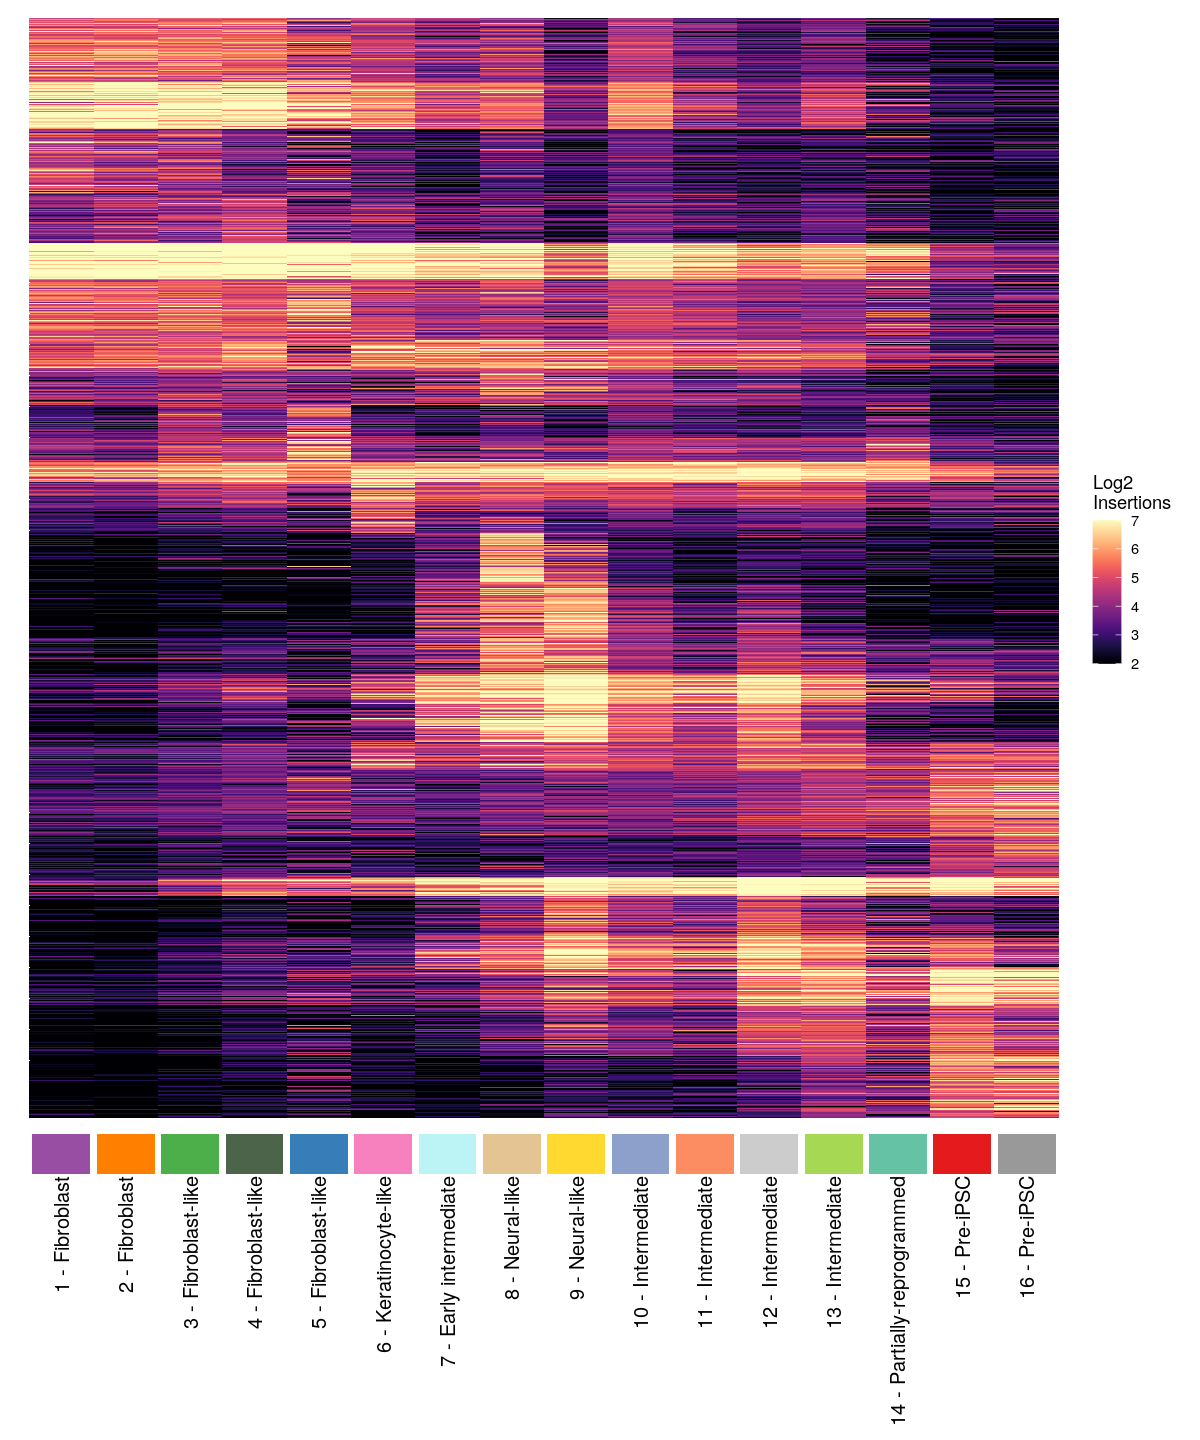

In [470]:
options(repr.plot.width = 10, repr.plot.height = 12)

cluster_by_day_with_colourbar = wrap_plots(heatmap, cluster_colourbar, nrow=2, heights=c(10,0.4))
cluster_by_day_with_colourbar